We want to solve a 2-d problem with Gaussian increments over time and Laplacian increments over trials, with loss function (negative log-likelihood):
\begin{equation}
L(x,z;\Delta N) = \sum\limits_{k=1}^{K} \sum\limits_{r=1}^{R} \left[ -\Delta N_{k,r} \, (x_k + z_r) + \log(1+e^{x_k + z_r}) \right] + \frac{1}{2\sigma} \sum\limits_{k=2}^{K} (x_k - x_{k-1})^2 + \lambda \sum\limits_{r=2}^{R} |z_r - z_{r-1}|
\end{equation}

In order to improve convergence and allow the use of
Theorem 4.3 (Stationarity With Block Alternation)
from [Jacobson&Fessler, 2007] (also on our slack channel),
we replace the L1 norm with a Huber loss with small quadratic region (e.g., $c=10^{-3}$):
\begin{equation}
|x| \simeq
H_c(x) =
\begin{cases}
\frac12 (c + \frac{1}{c} x^2) & \text{if $|x| < c$} \\
x & \text{if $|x| \geq c$}.
\end{cases}
\end{equation}

We obtain:
\begin{equation}
L_c(x,z;\Delta N) = \sum\limits_{k=1}^{K} \sum\limits_{r=1}^{R} \left[ -\Delta N_{k,r} \, (x_k + z_r) + \log(1+e^{x_k + z_r}) \right] + \frac{1}{2\sigma} \sum\limits_{k=2}^{K} (x_k - x_{k-1})^2 + \lambda \sum\limits_{r=2}^{R} H_c(z_r - z_{r-1})
\end{equation}

We can now write a quadratic majorizer w.r.t. the variables $z$ as:
\begin{align}
\phi_z(z;\bar x, \bar z) &= \sum\limits_{k=1}^{K} \sum\limits_{r=1}^{R} \left[ -\Delta N_{k,r} \, (\bar x_k + z_r) + \log(1+e^{\bar x_k + \bar z_r}) + (1 + e^{-(\bar x_k + \bar z_r)})^{-1} (z_r - \bar z_r) + \frac{1}{2} \frac{(z_r - \bar z_r)^2}{4} \right] \\
&+ \frac{1}{2\sigma} \sum\limits_{k=2}^{K} (\bar x_k - \bar x_{k-1})^2 + \lambda \sum\limits_{r=2}^{R} \frac12 \left[ \max(c, |\bar z_r - \bar z_{r-1}|) + \frac{(z_r - z_{r-1})^2}{\max(c, |\bar z_r - \bar z_{r-1}|)} \right] \\
&= \sum\limits_{k=1}^{K} \sum\limits_{r=1}^{R} \left[ -\Delta N_{k,r} \, z_r + \frac{z_r - \bar z_r}{1 + e^{-(\bar x_k + \bar z_r)}} + \frac{(z_r - \bar z_r)^2}{2 \cdot 4} \right] + \frac{\lambda}{2} \sum\limits_{r=2}^{R} \frac{(z_r - z_{r-1})^2}{\max(c, |\bar z_r - \bar z_{r-1}|)} + \mathrm{const}
\end{align}
which is quadratic in $z$ and can be solved exactly in one iteration using a simple Kalman filter-smoother.
For the quadratic term of the likelihood term, we have used the following fact about the second derivative of the logistic loss:
\begin{equation}
\frac{d}{dx}(\log(1 + e^x)) = \frac{1}{e^x + 2 + e^{-x}} \leq \frac{1}{4}.
\end{equation}
A less conservative, expansion-point-dependent quadratic majorizer is the one with second derivative $\max(4, 2 + |\bar x_k + \bar z_r|)^{-1}$. Even less conservative options may be sought if needed.

A quadratic majorizer w.r.t. the variables $x$ is:
\begin{align}
\phi_x(x;\bar x, \bar z)
&= \sum\limits_{k=1}^{K} \sum\limits_{r=1}^{R} \left[ -\Delta N_{k,r} \, x_k + \frac{x_k - \bar x_k}{1 + e^{-(\bar x_k + \bar z_r)}} + \frac{(x_k - \bar x_k)^2}{2 \cdot 4} \right] + \frac{1}{2\sigma} \sum\limits_{k=2}^{K} (x_k - x_{k-1})^2 + \mathrm{const}.
\end{align}

Because the function $L_c$ is coercive and the majorizers have uniform upper and lower curvature bounds, conditions (R1), (R2), (R3), (C4), (C5) and (C6) from [Jacobson&Fessler, 2007] hold. This guarantees the convergence of an algorithm that cyclically alternates MM steps over $x$ and $z$.

A possible advantage of this algorithm is that it uses one Kalman filter-smoother over $x$, then one over $z$ alternatively. In a sense, $x$ and $z$ are improved gradually together. Alternative solutions perform multiple Kalman iterations over $x$ for a fixed and possibly suboptimal value of $z$, therefore spending unnecessary effort trying to fine tune $x$ to refine a solution which is off anyway because of a suboptimal $z$ (and vice versa).

In [1]:
import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
def Do_Kalman_Likelihood(y, sigma2obs, sigma2e, x0):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model

    :param y: Observations (K,)
    :param sigma2obs: Variance of observation noise (vector)
    :param sigma2e: Variance of process noise (vector: sigma2e[i] variance of x[i] - x[i-1])
    :param x0: Initial value of state
    :return: x_map, L, marginal_loglikelihood, joint_loglikelihood
    """
    # Build diagonals of information matrix
    assert(len(y) == len(sigma2obs) and len(y) == len(sigma2e))
    D = 1. / sigma2obs + 1. / sigma2e + np.concatenate((1. / sigma2e[1:], [0.]))
    B = -1. / sigma2e
    B[0] = 0.
    
    # Find Cholesky factorization of Hessian
    U = sp.linalg.cholesky_banded((B, D), lower=False)

    # Solve linear system
    G = y / sigma2obs
    G[0] += x0 / sigma2e[0]
    x_map = sp.linalg.cho_solve_banded([U, False], G)

    # Compute joint and marginal probabilities
    joint_loglikelihood = -.5 * ( np.sum(np.log(2*np.pi*sigma2e)) + np.sum(np.diff(x_map)**2 / sigma2e[1:])
                                                                  + (x_map[0] - x0)**2 / sigma2e[0]
                                + np.sum(np.log(2*np.pi*sigma2obs)) + np.sum((y - x_map)**2 / sigma2obs) )
    marginal_loglikelihood = len(y)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [3]:
def Do_MM(DN, c, lam, sigma2x, sigma2x0, x0, sigma2z0, z0, max_iter=100, tol=1e-6):
    """Find MAP solution of 2d model using MM

    :param dN: Observations (R,K,)
    :param c: Radius of Huber approximation to L1 norm
    :param lam: Coefficient of L1 penalization of changes along z
    :param sigma2x: Variance of x process noise
    :param sigma2x0: Variance of initial state x
    :param x0: Initial value of state x
    :param sigma2z0: Variance of initial state z
    :param z0: Initial value of state z
    :return: x_map, z_map, loglikelihood_map
    """
    # Initialize
    z = np.zeros((DN.shape[0],))
    x = np.zeros((DN.shape[1],))
    xz = x[None,:] + z[:,None]
    joint_loglikel = np.zeros(max_iter)
    # Iterate
    for i in range(max_iter):
        # Block MM over z
        B = 1. / np.sum(1. / np.maximum(4., 2. + np.abs(xz)), axis=1)
        A = np.sum(1. / (1. + np.exp(-xz)) - DN, axis=1)
        sigma2z = np.concatenate(([sigma2z0], np.maximum(c, np.abs(np.diff(z))) / lam))
        z = Do_Kalman_Likelihood(z - A*B, B, sigma2z, z0)[0]
        xz = x[None,:] + z[:,None]
        # Block MM over x
        B = 1. / np.sum(1. / np.maximum(4., 2. + np.abs(xz)), axis=0)
        A = np.sum(1. / (1. + np.exp(-xz)) - DN, axis=0)
        sigma2x_ = np.concatenate(([sigma2x0], np.ones(len(x)-1) * sigma2x))
        x = Do_Kalman_Likelihood(x - A*B, B, sigma2x_, x0)[0]
        xz = x[None,:] + z[:,None]
        # Compute likelihood
        joint_loglikel[i] = ( np.sum(DN * xz - np.log(1. + np.exp(xz))) - .5 * (
                           (len(x) - 1) * np.log(2*np.pi*sigma2x) + np.sum(np.diff(x)**2 / sigma2x)
                           + np.log(2*np.pi*sigma2x0) + (x[0] - x0)**2 / sigma2x0 
                           + np.log(2*np.pi*sigma2z0) + (z[0] - z0)**2 / sigma2z0 )
                           + np.log(lam/2.) - lam * np.sum(np.abs(np.diff(z))) )
        # Check convergence
        if i > 0 and joint_loglikel[i] - joint_loglikel[i-1] < tol * np.abs(joint_loglikel[i]):
            return x, z, joint_loglikel[:i+1]
    return x, z, joint_loglikel

<IPython.core.display.Javascript object>


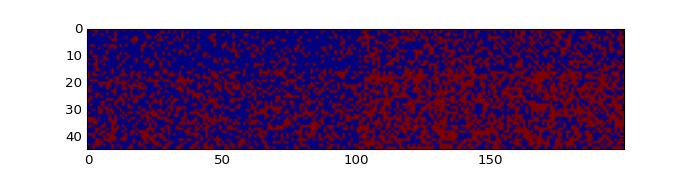

In [4]:
K = 200
R = 45
x = .1 + .2 * (np.arange(K) > 100)
z = .1 + .2 * (np.arange(R) > 15)
DN = (x[None,:] + z[:,None] > np.random.rand(R, K)).astype(float)
plt.figure()
plt.imshow(DN)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


<IPython.core.display.Javascript object>


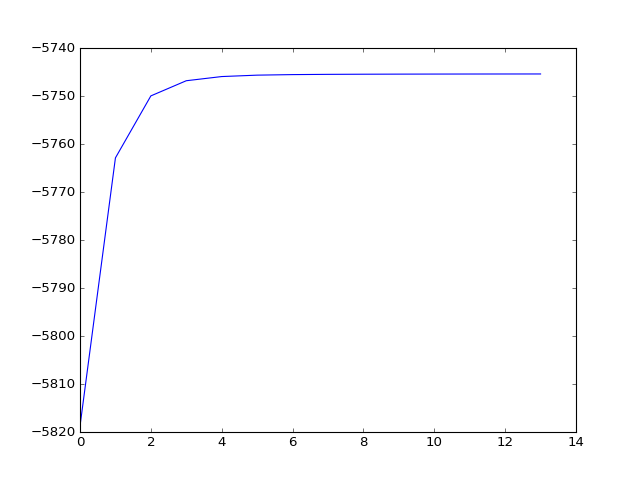

-5745.4095864


In [5]:
%time
c = 1e-3
sigma2x = .1
sigma2x0 = 10
x0 = 0
sigma2z0 = 10
z0 = 0
lam = 10.
x, z, joint_loglikel = Do_MM(DN, c, lam, sigma2x, sigma2x0, x0, sigma2z0, z0)
plt.figure()
plt.plot(joint_loglikel)
print(joint_loglikel[-1])

<IPython.core.display.Javascript object>


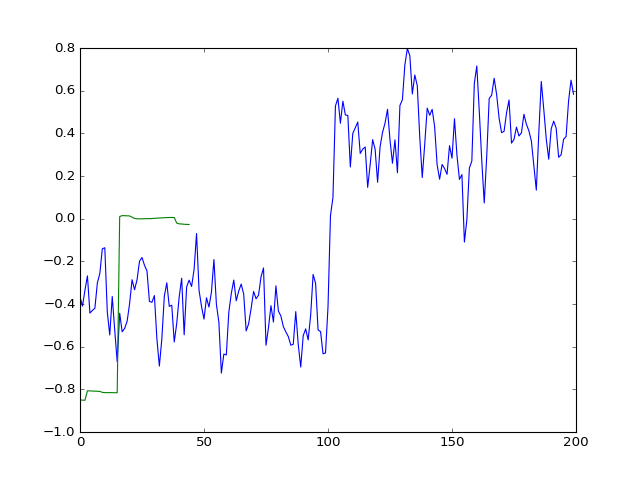

In [6]:
plt.figure()
plt.plot(x)
plt.plot(z)